In [248]:
import torch
from PIL import Image
from torchvision.transforms import v2
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.v2.functional import to_pil_image
from torchvision import tv_tensors

from yolo.data import CollateWithAnchors, CocoDataset, get_val_transforms, labels_getter
from yolo.model import Yolo
from yolo.visualize import plot


In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
IMAGE_SIZE = 608
ANCHORS = [
    (10,13),
    (16,30),
    (33,23),
    (30,61),
    (62,45),
    (59,119),
    (116,90),
    (156,198),
    (373,326)
]
SCALES = [8, 16, 32]

train_dataset = CocoDataset(
    dataset_root = "/media/bryan/ssd01/fiftyone/coco-2017",
    split = "train",
)

loading annotations into memory...
Done (t=4.71s)
creating index...
index created!


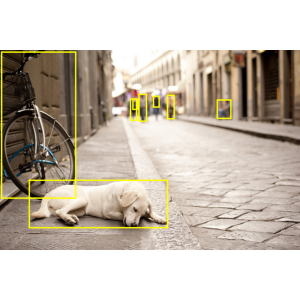

In [28]:
sample = train_dataset[12]
vis = plot([sample])
Image.fromarray(vis)

In [297]:
# Define the transformation pipeline
transform = v2.Compose([
    v2.ToImage(),  # Convert PIL image to tensor
    v2.RandomHorizontalFlip(p=0.5),  # YOLO models perform well with horizontal flips
#     v2.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 0.8)),  # Minor distortions
    v2.RandomPhotometricDistort(
        brightness = (0.875, 1.125),
        contrast = (0.7, 1.3),
        saturation = (0.8, 1.2),
        hue = (-0.05, 0.05),
        p=.25
    ),
#     v2.RandomPhotometricDistort(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1, p=0.25),
#     v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
#     v2.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),
#     v2.RandomErasing(p=1, scale=(0.01, 0.01), ratio=(0.3, 3.3)),  # Cutout-like effect
#     v2.RandomZoomOut(fill={tv_tensors.Image: (123, 117, 104), "others": 0}),
#     v2.RandomIoUCrop(min_scale=0.8, max_scale=1, min_aspect_ratio=0.5, max_aspect_ratio=2),
    v2.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # resize the image. bilinear
    v2.ClampBoundingBoxes(),  # clamp bounding boxes to be within the image
    v2.SanitizeBoundingBoxes(
        labels_getter=labels_getter
    )
])

# transforms.Resize((608, 608)),  # Resize the image
# transforms.ToDtype(torch.float32, scale=True),  # Normalize expects float input
# transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),

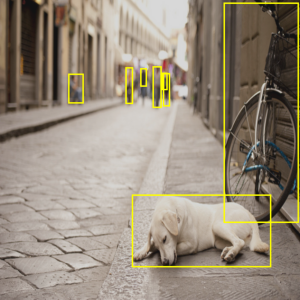

In [307]:
sample_trans = transform(sample)
Image.fromarray(plot([sample_trans]))

In [66]:
labels = [train_dataset.class_names[i] for i in sample_trans[1]["class_idx"].tolist()]

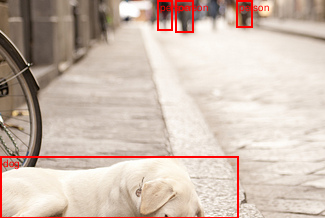

In [90]:
# https://github.com/pytorch/vision/blob/main/torchvision/utils.py
# free fonts: /usr/share/fonts/truetype/freefont
vis = draw_bounding_boxes(
    sample_trans[0],
    sample_trans[1]["boxes"],
    labels=labels,
    colors = "red",
    fill = False,
    width = 2,
    font = "FreeSans.ttf",
    font_size = 10,
    label_colors = "red",
)
to_pil_image(vis.detach())